In [1]:
library(limma) 
library(edgeR)

In [2]:
# load data
counts = read.csv('../../bulkRNAseq/counts.txt', comment="#", sep="\t", check.names=FALSE)
metadata = read.csv('../../bulkRNAseq/abca7_rna_seq_metadata_with_seqIDs.csv', check.names=FALSE)
metadata$SeqID = gsub(" ", "", metadata$SeqID)

sam_columns = grep("\\.sam$", names(counts), value = TRUE)
counts_subset = counts[,sam_columns[2:length(sam_columns)]]
colnames(counts_subset) <- sapply(strsplit(colnames(counts_subset), "_"), function(x) x[2])
names(counts_subset) == metadata$SeqID

counts_pc = counts_subset[counts$gene_type=='protein_coding',]
names = counts$Geneid[counts$gene_type=='protein_coding']
gene_names = counts$gene_name[counts$gene_type=='protein_coding']
row.names(counts_pc) = names

lib.size = colSums(counts_subset)


[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [3]:
# create DGEList
dge_obj = DGEList(counts=counts_pc,genes=gene_names, samples=metadata, lib.size=lib.size)
isexpr = rowSums(cpm(dge_obj) >= 1) >= 1
dge_obj = dge_obj[isexpr,]

# compute choline-assoc genes
subset_x = dge_obj[,grepl("batch 1", dge_obj$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Line=='Y622']
mod1 = model.matrix(~subset_x$samples$Treatment=='Choline2Weeks')
colnames(mod1) = c('intercept', 'condition')
v = voom(subset_x, design=mod1, plot = FALSE)
fit = lmFit(v, design=mod1)
fit = eBayes(fit)
res_choline = topTable(fit, coef='condition', n=Inf, sort.by="P")

# compute choline-assoc genes
subset_x = dge_obj[,grepl("batch 2", dge_obj$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Line=='Y622']
mod1 = model.matrix(~subset_x$samples$Treatment=='Choline2Weeks')
colnames(mod1) = c('intercept', 'condition')
v = voom(subset_x, design=mod1, plot = FALSE)
fit = lmFit(v, design=mod1)
fit = eBayes(fit)
res_choline_batch2 = topTable(fit, coef='condition', n=Inf, sort.by="P")

# compute y622-assoc genes
subset_x = dge_obj[,grepl("batch 1", dge_obj$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Treatment=='H20' & subset_x$samples$Line!='G2']
mod1 = model.matrix(~subset_x$samples$Line=='Y622')
colnames(mod1) = c('intercept', 'condition')
v = voom(subset_x, design=mod1, plot = FALSE)
fit = lmFit(v, design=mod1)
fit = eBayes(fit)
res_y622 = topTable(fit, coef='condition', n=Inf, sort.by="P")


# compute y622-assoc genes
subset_x = dge_obj[,grepl("batch 1", dge_obj$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Treatment=='H20' & subset_x$samples$Line!='Y622']
mod1 = model.matrix(~subset_x$samples$Line=='G2')
colnames(mod1) = c('intercept', 'condition')
v = voom(subset_x, design=mod1, plot = FALSE)
fit = lmFit(v, design=mod1)
fit = eBayes(fit)
res_g2 = topTable(fit, coef='condition', n=Inf, sort.by="P")


In [14]:
table(metadata$Notes, metadata$Treatment, metadata$Line)

, ,  = Control

                                                                        
                                                                         Choline2Weeks
  diff & extraction batch 1 (1 well, DOI:101624, JennyExtraction 111324)             0
  diff & extraction batch 2 (2 wells pooled)                                         0
                                                                        
                                                                         H20
  diff & extraction batch 1 (1 well, DOI:101624, JennyExtraction 111324)   2
  diff & extraction batch 2 (2 wells pooled)                               0

, ,  = G2

                                                                        
                                                                         Choline2Weeks
  diff & extraction batch 1 (1 well, DOI:101624, JennyExtraction 111324)             0
  diff & extraction batch 2 (2 wells pooled)                                         0


In [4]:
write.csv(res_y622, "../../bulkRNAseq/y622_degs.csv")
write.csv(res_choline, "../../bulkRNAseq/choline_degs.csv")
write.csv(res_g2, "../../bulkRNAseq/g2_degs.csv")
write.csv(res_choline_batch2, "../../bulkRNAseq/choline_batch2_degs.csv")

### Below is scrap

In [44]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("BiocParallel")
library(fgsea)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocParallel'

Warning message in install.packages(...):
“installation of package ‘BiocParallel’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'bit64', 'caret', 'clock', 'curl', 'edgeR', 'gower', 'limma',
  'ps', 'purrr', 'textshaping'



ERROR: Error in library(fgsea): there is no package called ‘fgsea’


In [ ]:
# run fgsea

# compute fgsea results
all_paths = read.csv('../../processed_data/all_paths.csv', row.names = 'X')
pathways = as.list(as.data.frame(t(all_paths)))
temp = lapply(names(pathways), function(x) pathways[[x]][!(pathways[[x]]=='')])
names(temp) = names(pathways)

In [ ]:
res_choline_batch2$scores = sign(res_choline_batch2$logFC)*-log10(res_choline_batch2$P.Value)
scores = res_choline_batch2$scores
names(scores) = res_choline_batch2$genes

In [ ]:

              
out = lapply(names(scores), function(x) cbind(x, fgsea(pathways = temp, stats = scores[[x]]$scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)))
names(out) = names(scores)

In [21]:
# create DGEList
x = DGEList(counts=counts_pc,genes=names, samples=metadata)
# compute DEGs
isexpr = rowSums(cpm(x) >= 1) >= 1
x = x[isexpr,]

subset_x = x[,grepl("batch 2", x$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Line=='Y622']

mod1 = model.matrix(~subset_x$samples$Treatment=='Choline2Weeks')
colnames(mod1) = c('intercept', 'condition')
v = voom(subset_x, design=mod1, plot = FALSE)
fit = lmFit(v, design=mod1)
fit = eBayes(fit)
res_choline_batch2 = topTable(fit, coef='condition', n=Inf, sort.by="P")


In [10]:
# create DGEList
x = DGEList(counts=counts_pc,genes=names, samples=metadata)
# compute DEGs
isexpr = rowSums(cpm(x) >= 1) >= 1
x = x[isexpr,]

subset_x = x#[,grepl("batch 2", x$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Line=='Y622']

mod1 = model.matrix(~subset_x$samples$Treatment=='Choline2Weeks')
colnames(mod1) = c('intercept', 'condition')
v = voom(subset_x, design=mod1, plot = FALSE)
fit = lmFit(v, design=mod1)
fit = eBayes(fit)
res_choline_batch1_2 = topTable(fit, coef='condition', n=Inf, sort.by="P")


In [ ]:
all_paths = read.csv('../../ABCA7lof2/processed_data/genesets/all_paths.csv', row.names = 'X')
pathways = as.list(as.data.frame(t(all_paths)))
temp = lapply(names(pathways), function(x) pathways[[x]][!(pathways[[x]]=='')])
names(temp) = names(pathways)


res_choline_batch1_2$scores = sign(res_choline_batch1_2$logFC)*-log10(res_choline_batch1_2$P.Value)
scores = res_choline_batch1_2$scores
names(scores) = res_choline_batch1_2$genes

library(fgsea)
pathways = readRDS('/home/gridsan/djuna/homer/github/archived_repos/APOE_myelin_2022/re-submission_code_31012022/data/pathways.rds')
related_pathways = pathways$pathways$all_bp[grep("phospholipid", names(pathways$pathways$all_bp), value = TRUE)]
out = fgsea(pathways = related_pathways, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
out[order(out$pval),]


`geom_smooth()` using formula 'y ~ x'



[1] "Pearson correlation coefficient: 0.44985340022726"
[1] "P-value of the Pearson correlation coefficient: 0"


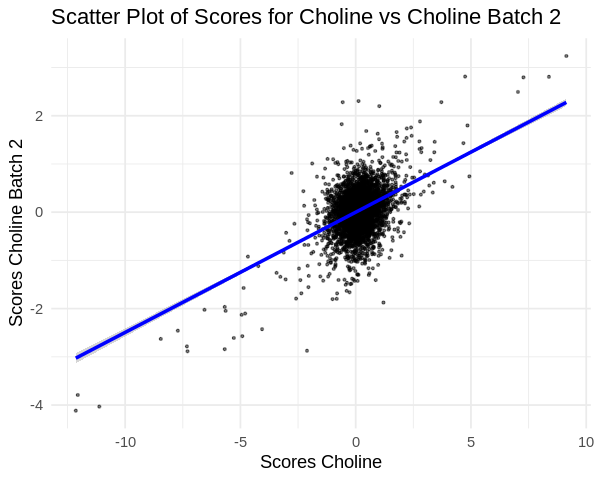

In [113]:
options(repr.plot.width=5, repr.plot.height=4)

merged = merge(res_choline, res_choline_batch2, by='row.names', suffixes=c('_choline', '_choline_batch2'))
library(ggplot2)
merged$scores_choline = sign(merged$logFC_choline)*-log10(merged$P.Value_choline)
merged$scores_choline_batch2 = sign(merged$logFC_choline_batch2)*-log10(merged$P.Value_choline_batch2)
# Create a scatter plot of scores for g2 vs y622

ggplot(merged, aes(x = logFC_choline, y = logFC_choline_batch2)) +
  geom_point(alpha = 0.5, size=0.5) +
  theme_minimal() +
  labs(title = "Scatter Plot of Scores for Choline vs Choline Batch 2", x = "Scores Choline", y = "Scores Choline Batch 2") +
  geom_smooth(method = "lm", se = TRUE, color = "blue") #+ xlim(-1, 1) + ylim(-1, 1)
# Calculate and print the Pearson correlation coefficient
correlation_coefficient <- cor(merged$logFC_choline, merged$logFC_choline_batch2, method = "pearson")
print(paste("Pearson correlation coefficient:", correlation_coefficient))
# Calculate and print the p-value of the Pearson correlation coefficient
correlation_test <- cor.test(merged$logFC_choline, merged$logFC_choline_batch2, method = "pearson")
print(paste("P-value of the Pearson correlation coefficient:", correlation_test$p.value))



In [33]:
names

[1] "OR4F5"                   "OR4F29"                 
    [3] "OR4F16"                  "SAMD11"                 
    [5] "NOC2L"                   "KLHL17"                 
    [7] "PLEKHN1"                 "PERM1"                  
    [9] "HES4"                    "ISG15"                  
   [11] "AGRN"                    "RNF223"                 
   [13] "C1orf159"                "TTLL10"                 
   [15] "TNFRSF18"                "TNFRSF4"                
   [17] "SDF4"                    "B3GALT6"                
   [19] "C1QTNF12"                "UBE2J2"                 
   [21] "SCNN1D"                  "ACAP3"                  
   [23] "PUSL1"                   "INTS11"                 
   [25] "CPTP"                    "TAS1R3"                 
   [27] "DVL1"                    "MXRA8"                  
   [29] "AURKAIP1"                "CCNL2"                  
   [31] "MRPL20"                  "ANKRD65"                
   [33] "TMEM88B"                 "VWA1"                   
   [35] "ATAD3C"                  "ATAD3B"                 
   [37] "ATAD3A"                  "TMEM240"                
   [39] "SSU72"                   "FNDC10"                 
   [41] "MIB2"                    "MMP23B"                 
   [43] "CDK11B"                  "SLC35E2B"               
   [45] "CDK11A"                  "NADK"                   
   [47] "GNB1"                    "CALML6"                 
   [49] "TMEM52"                  "CFAP74"                 
   [51] "GABRD"                   "PRKCZ"                  
   [53] "FAAP20"                  "SKI"                    
   [55] "MORN1"                   "RER1"                   
   [57] "PEX10"                   "PLCH2"                  
   [59] "PANK4"                   "HES5"                   
   [61] "TNFRSF14"                "PRXL2B"                 
   [63] "MMEL1"                   "TTC34"                  
   [65] "ACTRT2"                  "PRDM16"                 
   [67] "ARHGEF16"                "MEGF6"                  
   [69] "TPRG1L"                  "WRAP73"                 
   [71] "TP73"                    "CCDC27"                 
   [73] "SMIM1"                   "LRRC47"                 
   [75] "CEP104"                  "DFFB"                   
   [77] "C1orf174"                "AJAP1"                  
   [79] "NPHP4"                   "KCNAB2"                 
   [81] "CHD5"                    "ENSG00000285629"        
   [83] "RPL22"                   "RNF207"                 
   [85] "ICMT"                    "HES3"                   
   [87] "GPR153"                  "ACOT7"                  
   [89] "HES2"                    "ESPN"                   
   [91] "TNFRSF25"                "PLEKHG5"                
   [93] "NOL9"                    "TAS1R1"                 
   [95] "ZBTB48"                  "KLHL21"                 
   [97] "PHF13"                   "THAP3"                  
   [99] "DNAJC11"                 "CAMTA1"                 
  [101] "VAMP3"                   "PER3"                   
  [103] "UTS2"                    "TNFRSF9"                
  [105] "PARK7"                   "ERRFI1"                 
  [107] "SLC45A1"                 "RERE"                   
  [109] "ENO1"                    "CA6"                    
  [111] "SLC2A7"                  "SLC2A5"                 
  [113] "GPR157"                  "H6PD"                   
  [115] "SPSB1"                   "SLC25A33"               
  [117] "TMEM201"                 "PIK3CD"                 
  [119] "CLSTN1"                  "CTNNBIP1"               
  [121] "LZIC"                    "NMNAT1"                 
  [123] "RBP7"                    "UBE4B"                  
  [125] "KIF1B"                   "PGD"                    
  [127] "CENPS-CORT"              "CENPS"                  
  [129] "CORT"                    "DFFA"                   
  [131] "PEX14"                   "CASZ1"                  
  [133] "C1orf127"                "TARDBP"  

In [87]:
# compute fgsea results
all_paths = read.csv('../ABCA7lof2/processed_data/genesets/all_paths.csv', row.names = 'X')
pathways = as.list(as.data.frame(t(all_paths)))
temp = lapply(names(pathways), function(x) pathways[[x]][!(pathways[[x]]=='')])
names(temp) = names(pathways)

print(length(temp))

res_choline_batch2$scores = sign(res_choline_batch2$logFC)*-log10(res_choline_batch2$P.Value)
scores = res_choline_batch2$scores
names(scores) = res_choline_batch2$genes

library(fgsea)
pathways = readRDS('/home/gridsan/djuna/homer/github/archived_repos/APOE_myelin_2022/re-submission_code_31012022/data/pathways.rds')
related_pathways = pathways$pathways$all_bp[grep("fatty acid", names(pathways$pathways$all_bp), value = TRUE)]
out = fgsea(pathways = related_pathways, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
out[order(out$pval),]


[1] 472


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
positive regulation of fatty acid beta-oxidation (GO:0032000),0.01407915,0.1375404,0.16765853,0.8271053,1.5813356,5,"ABCD2, IRS1 , AKT2 , IRS2 , PPARA"
positive regulation of fatty acid oxidation (GO:0046321),0.01802478,0.1375404,0.14692214,0.7246501,1.6038286,8,"ABCD2, IRS1 , AKT2 , IRS2 , PPARA"
regulation of fatty acid oxidation (GO:0046320),0.02375691,0.1375404,0.12644847,0.6594785,1.6071089,11,"FABP3 , ACADVL, LONP2 , SIRT4 , PPARA"
"fatty acid elongation, monounsaturated fatty acid (GO:0034625)",0.02468674,0.1375404,0.12497879,0.7367980,1.5717538,7,"ELOVL6, ELOVL3, ELOVL5"
"fatty acid elongation, polyunsaturated fatty acid (GO:0034626)",0.02468674,0.1375404,0.12497879,0.7367980,1.5717538,7,"ELOVL6, ELOVL3, ELOVL5"
"fatty acid elongation, saturated fatty acid (GO:0019367)",0.02468674,0.1375404,0.12497879,0.7367980,1.5717538,7,"ELOVL6, ELOVL3, ELOVL5"
"fatty acid elongation, unsaturated fatty acid (GO:0019368)",0.02468674,0.1375404,0.12497879,0.7367980,1.5717538,7,"ELOVL6, ELOVL3, ELOVL5"
regulation of fatty acid beta-oxidation (GO:0031998),0.02891476,0.1409594,0.11554753,0.7040799,1.5583018,8,"ABCD2, LONP2, IRS1 , AKT2 , IRS2 , PPARA"
unsaturated fatty acid biosynthetic process (GO:0006636),0.04805195,0.2082251,0.09585696,-0.6460788,-1.5233524,9,"ALOX12B, ALOXE3 , HPGD , FADS3"


In [25]:
res_y622[order(res_y622$P.Value),]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35613,KHDRBS3,-8.2451469,1.5488386,-39.91392,1.551805e-14,2.048073e-10,19.646125
76192,RRAGB,-9.2866571,0.7910360,-32.69878,1.824847e-13,1.204216e-09,17.090536
43443,CAT,-9.2494853,-1.9717710,-25.19190,4.509027e-12,1.776756e-08,13.299582
77796,MAGEA4,11.1774199,5.4941247,24.82931,5.384926e-12,1.776756e-08,11.903158
40093,ZNF248,-7.5166707,0.8302378,-22.95941,1.402193e-11,3.701228e-08,15.367221
35735,THEM6,-3.1769449,2.1980231,-20.64448,5.113266e-11,1.124748e-07,15.593544
77395,ARHGAP36,-1.4978570,7.3445614,-18.53945,1.879624e-10,3.543897e-07,14.477243
77819,MAGEA12,11.5728069,4.6535332,17.92530,2.820922e-10,4.653816e-07,8.893082
45887,HTR3A,-2.4414040,3.5875519,-17.65145,3.394953e-10,4.978511e-07,13.955644


In [4]:
##### E3 vs G2
# create DGEList
x = DGEList(counts=counts_pc,genes=names, samples=metadata)
# compute DEGs
isexpr = rowSums(cpm(x) >= 1) >= 1
x = x[isexpr,]

subset_x = x[,grepl("batch 1", x$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Treatment=='H20']
subset_x = subset_x[,subset_x$samples$Line!='Y622']

mod1 = model.matrix(~subset_x$samples$Line=='G2')
colnames(mod1) = c('intercept', 'condition')
v = voom(subset_x, design=mod1, plot = FALSE)
fit = lmFit(v, design=mod1)
fit = eBayes(fit)
res_g2 = topTable(fit, coef='condition', n=Inf, sort.by="P")

##### E3 vs Y622

# create DGEList
x = DGEList(counts=counts_pc,genes=names, samples=metadata)
# compute DEGs
isexpr = rowSums(cpm(x) >= 1) >= 1
x = x[isexpr,]

subset_x = x[,grepl("batch 1", x$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Treatment=='H20']
subset_x = subset_x[,subset_x$samples$Line!='G2']

mod1 = model.matrix(~subset_x$samples$Line=='Y622')
colnames(mod1) = c('intercept', 'condition')
v = voom(subset_x, design=mod1, plot = FALSE)
fit = lmFit(v, design=mod1)
fit = eBayes(fit)
res_y622 = topTable(fit, coef='condition', n=Inf, sort.by="P")



In [19]:
cpm_counts = cpm(counts_pc)
row.names(cpm_counts) = names

In [20]:
x = cpm_counts[row.names(cpm_counts)%in%c('SLC25A43', 'SLC25A23', 'SLC25A1', 'SLC25A25', 'SLC25A44', 'SLC25A36'),]
x_reshaped = reshape2::melt(x)
row.names(metadata) = metadata$SeqID
x_reshaped$line = as.character(metadata[as.character(x_reshaped$Var2), 'Line'])
x_reshaped$treatment = as.character(metadata[as.character(x_reshaped$Var2), 'Treatment'])
x_reshaped$batch = as.character(metadata[as.character(x_reshaped$Var2), 'Notes'])
x_reshaped = x_reshaped[x_reshaped$batch=='diff & extraction batch 1 (1 well, DOI:101624, JennyExtraction 111324)',]

In [21]:
x_reshaped$value = as.numeric(x_reshaped$value)

In [22]:
x_reshaped$grp = paste(x_reshaped$line, x_reshaped$treatment, sep='_')
x_reshaped$grp = factor(x_reshaped$grp, levels = c('Control_H20', 'Y622_H20', 'G2_H20', 'Y622_Choline2Weeks'))

Warning message:
"package 'ggpubr' was built under R version 3.6.3"

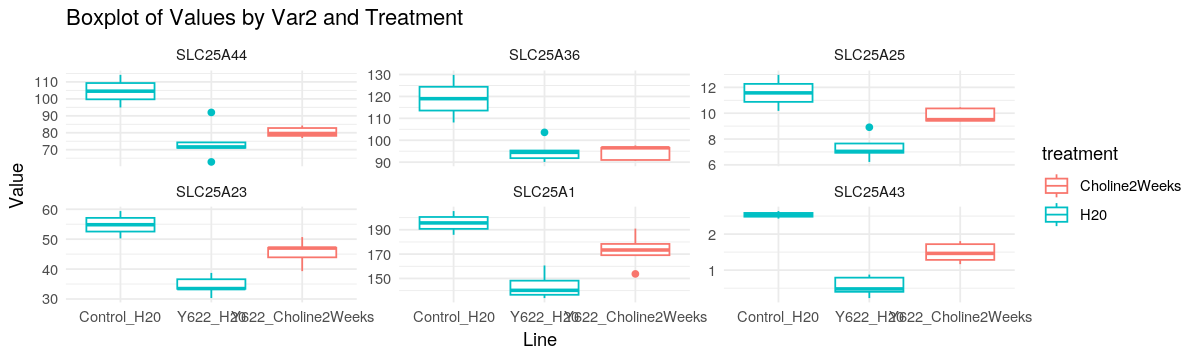

In [23]:
library(ggplot2)
library(ggpubr)
options(repr.plot.width=10, repr.plot.height=3)

ggplot(x_reshaped[x_reshaped$line!='G2',], aes(x = grp, y = value, color = treatment)) +
  geom_boxplot() +
  facet_wrap(~ Var1, scales = "free_y") +
  theme_minimal() +
  labs(title = "Boxplot of Values by Var2 and Treatment", x = "Line", y = "Value") 


In [24]:
res_y622[grep("^TOMM", res_y622$genes), ]
res_g2[grep("^TOMM", res_g2$genes), ]
res_choline[grep("^TOMM", res_choline$genes), ]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
74548,TOMM22,0.401347396,7.131634,3.51791957,0.004011072,0.03804309,-3.104777
69051,TOMM40,-0.175242835,6.377486,-2.07703178,0.059074766,0.18288877,-5.700523
29175,TOMM7,0.311202292,6.989739,1.89983870,0.080820997,0.22257216,-6.019297
36732,TOMM5,0.253880450,4.693781,1.79626161,0.096700786,0.24805772,-5.957815
4717,TOMM40L,-0.075357714,4.164704,-0.55176351,0.590860229,0.74153999,-7.282235
14736,TOMM70,0.022043738,6.326960,0.16148165,0.874300586,0.92977818,-7.672519
71445,TOMM34,-0.008017919,5.716883,-0.07372653,0.942397301,0.96882377,-7.633692
6682,TOMM20,0.003830235,7.429562,0.03947900,0.969133450,0.98381842,-7.769249


,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
74548,TOMM22,0.47483385,7.185115,2.96766179,0.01234631,0.2230661,-3.802206
29175,TOMM7,0.36678665,7.032777,1.73436340,0.10976201,0.4424658,-5.881013
36732,TOMM5,0.18579456,4.647364,1.05551061,0.31303522,0.6265155,-6.568770
69051,TOMM40,-0.09731384,6.433863,-0.64478123,0.53182241,0.7755792,-7.082749
6682,TOMM20,-0.08934894,7.360910,-0.47932633,0.64076450,0.8327730,-7.230057
71445,TOMM34,-0.02108100,5.707229,-0.15960550,0.87598300,0.9490996,-7.237978
4717,TOMM40L,-0.02900476,4.192588,-0.14448903,0.88763566,0.9536087,-7.095860
14736,TOMM70,-0.01020797,6.301079,-0.05447019,0.95750290,0.9826690,-7.291969


,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36732,TOMM5,-0.424784692,4.556890,-4.5319155,0.0002634940,0.001965507,-0.6630124
6682,TOMM20,0.271480312,7.567250,4.3282039,0.0004124508,0.002780146,-1.4533673
14736,TOMM70,0.293673033,6.478078,3.4363124,0.0029751681,0.012289912,-3.3344785
4717,TOMM40L,0.256452947,4.271290,2.7282878,0.0138721354,0.039594387,-4.5305189
74548,TOMM22,-0.081907584,7.206218,-1.3126287,0.2059428583,0.313390274,-7.3113895
71445,TOMM34,-0.043892093,5.693510,-0.6610760,0.5170097444,0.628430154,-7.8049560
29175,TOMM7,0.052388292,7.105142,0.5175779,0.6111105927,0.709923211,-8.0301795
69051,TOMM40,-0.006120985,6.322162,-0.1018658,0.9199992419,0.945503037,-8.0947167


In [20]:
res_y622[grep("^DNM1L", res_y622$genes), ]
res_g2[grep("^DNM1L", res_g2$genes), ]
res_choline[grep("^DNM1L", res_choline$genes), ]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47579,DNM1L,-0.329362,7.551994,-2.463666,0.02916386,0.1205464,-5.123708


,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47579,DNM1L,-0.2953465,7.57323,-1.600901,0.1367101,0.4780868,-6.115915


,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47579,DNM1L,0.1919041,7.553752,2.270499,0.03580886,0.08149772,-5.818662


In [24]:
res_y622[grep("^PINK1", res_y622$genes), ]
res_g2[grep("^PINK1", res_g2$genes), ]
res_choline[grep("^PINK1", res_choline$genes), ]


,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
868,PINK1,-0.289257,6.798654,-2.799386,0.0155602,0.08204695,-4.456005


,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
868,PINK1,-0.1634138,6.88736,-1.083513,0.300952,0.6183876,-6.725857


,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
868,PINK1,0.02250379,6.725884,0.3400137,0.7378163,0.8094513,-8.076654


In [8]:
res_g2[grep("^UCP", res_g2$genes), ]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
44963,UCP2,-0.5193427,2.573851,-1.819053,0.09523054,0.4273555,-5.364018


In [11]:
res_choline_batch1_2[grep("^UCP", res_choline_batch1_2$genes), ]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
44963,UCP2,0.215454,2.313898,1.325217,0.2007979,0.4211904,-5.604538


`geom_smooth()` using formula 'y ~ x'



[1] "Pearson correlation coefficient: -0.486517897151645"


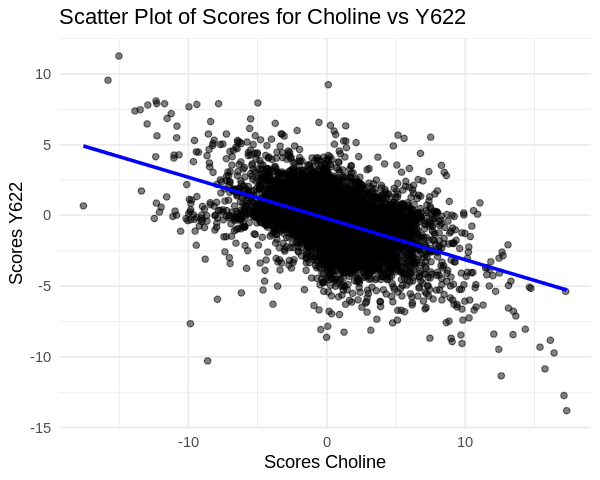

In [62]:
options(repr.plot.width=5, repr.plot.height=4)

merged = merge(res_choline, res_y622, by='row.names', suffixes=c('_choline', '_y622'))
library(ggplot2)
merged$scores_choline = sign(merged$logFC_choline)*-log10(merged$P.Value_choline)
merged$scores_y622 = sign(merged$logFC_y622)*-log10(merged$P.Value_y622)
# Create a scatter plot of scores for g2 vs y622

ggplot(merged, aes(x = scores_choline, y = scores_y622)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(title = "Scatter Plot of Scores for Choline vs Y622", x = "Scores Choline", y = "Scores Y622") +
  geom_smooth(method = "lm", se = TRUE, color = "blue")
# Calculate and print the Pearson correlation coefficient
correlation_coefficient <- cor(merged$scores_choline, merged$scores_y622, method = "pearson")
print(paste("Pearson correlation coefficient:", correlation_coefficient))


`geom_smooth()` using formula 'y ~ x'



[1] "Pearson correlation coefficient: 0.841518794538621"


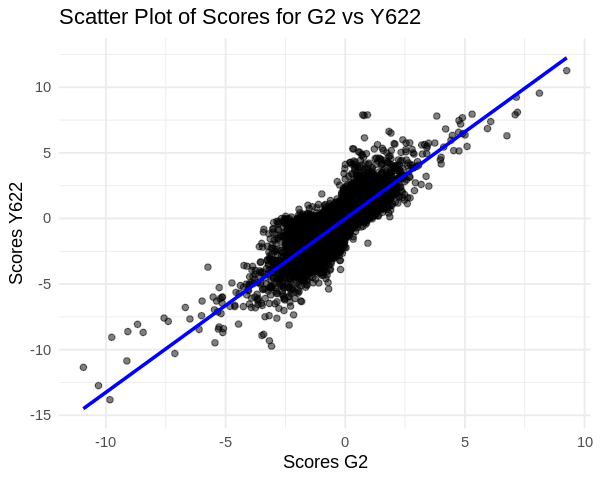

In [59]:
options(repr.plot.width=5, repr.plot.height=4)

merged = merge(res_g2, res_y622, by='row.names', suffixes=c('_g2', '_y622'))
library(ggplot2)
merged$scores_g2 = sign(merged$logFC_g2)*-log10(merged$P.Value_g2)
merged$scores_y622 = sign(merged$logFC_y622)*-log10(merged$P.Value_y622)
# Create a scatter plot of scores for g2 vs y622

ggplot(merged, aes(x = scores_g2, y = scores_y622)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  labs(title = "Scatter Plot of Scores for G2 vs Y622", x = "Scores G2", y = "Scores Y622") +
  geom_smooth(method = "lm", se = TRUE, color = "blue")
# Calculate and print the Pearson correlation coefficient
correlation_coefficient <- cor(merged$scores_g2, merged$scores_y622, method = "pearson")
print(paste("Pearson correlation coefficient:", correlation_coefficient))


In [23]:
# compute fgsea results
all_paths = read.csv('../ABCA7lof2/processed_data/genesets/all_paths.csv', row.names = 'X')
pathways = as.list(as.data.frame(t(all_paths)))
temp = lapply(names(pathways), function(x) pathways[[x]][!(pathways[[x]]=='')])
names(temp) = names(pathways)

print(length(temp))

res_g2$scores = sign(res_g2$logFC)*-log10(res_g2$P.Value)
scores = res_g2$scores
names(scores) = res_g2$genes

library(fgsea)
out = fgsea(pathways = temp, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
#out[order(out$pval),]


[1] 472


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


In [71]:
library(fgsea)
res_g2$scores = sign(res_g2$logFC)*-log10(res_g2$P.Value)
scores = res_g2$scores
names(scores) = res_g2$genes
pathways = readRDS('/home/gridsan/djuna/homer/github/archived_repos/APOE_myelin_2022/re-submission_code_31012022/data/pathways.rds')
related_pathways = pathways$pathways$all_bp[grep("oxidation", names(pathways$pathways$all_bp), value = TRUE)]
out = fgsea(pathways = related_pathways, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
out[order(out$pval),]

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
regulation of fatty acid oxidation (GO:0046320),0.01799806,0.1619826,0.12595293,-0.7024372,-1.5694311,11,"FABP3 , TYSND1, ACADL , LONP2 , ACADVL"
regulation of fatty acid beta-oxidation (GO:0031998),0.04847526,0.2181387,0.07731245,-0.7027942,-1.4569118,8,"TYSND1, ABCD2 , LONP2"
positive regulation of fatty acid beta-oxidation (GO:0032000),0.25144685,0.7543405,0.03244884,-0.6511307,-1.1911874,5,ABCD2
positive regulation of fatty acid oxidation (GO:0046321),0.49769850,0.9520577,0.01983714,-0.4804680,-0.9960234,8,"ABCD2 , PPARGC1A, MLYCD , AKT2"
fatty acid oxidation (GO:0019395),0.61064459,0.9520577,0.01396582,-0.3114268,-0.9184383,43,"ACAT2 , ABCD2 , PPARD , ACADL , ACADVL , ACAD10 , CYP4V2 , ECHDC2 , ALDH3A2 , EHHADH , HADHA , HIBCH , MECR , PHYH , PPARGC1A, ACADS , ADIPOR1 , ECI1 , ABCD3 , PECR , ACOX1 , BDH2 , HSD17B4 , PEX2 , ABCD1"
fatty acid beta-oxidation using acyl-CoA dehydrogenase (GO:0033539),0.65417987,0.9520577,0.01516913,-0.3825383,-0.8702157,12,"ACADL , ACADVL, ACAD10"
fatty acid beta-oxidation (GO:0006635),0.74048929,0.9520577,0.01099626,-0.2790137,-0.8318893,46,"ACAT2 , ABCD2 , PPARD , ACADL , ACADVL, ACAD10"
fatty acid beta-oxidation using acyl-CoA oxidase (GO:0033540),0.85148380,0.9579193,0.01116481,-0.3002788,-0.6965010,13,"EHHADH , ACOX3 , ACOX1 , HSD17B4, ABCD1 , CRAT , CROT"
fatty acid alpha-oxidation (GO:0001561),0.99457042,0.9945704,0.02145627,0.2046959,0.4746933,7,"SLC27A2, HACL1 , PEX13"


In [65]:
library(fgsea)
res_choline$scores = sign(res_choline$logFC)*-log10(res_choline$P.Value)
scores = res_choline$scores
names(scores) = res_choline$genes
pathways = readRDS('/home/gridsan/djuna/homer/github/archived_repos/APOE_myelin_2022/re-submission_code_31012022/data/pathways.rds')
related_pathways = pathways$pathways$all_bp[grep("phospholipid", names(pathways$pathways$all_bp), value = TRUE)]
out = fgsea(pathways = related_pathways, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
out[order(out$pval),]

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
glycerophospholipid biosynthetic process (GO:0046474),0.00785877,0.1100228,0.173713219,0.4247316,1.4555401,132,"CHAT , INPPL1 , SLC44A5 , PITPNM1 , LPCAT2 , GPD1L , OCRL , FGF2 , ETNK2 , ACP6 , PI4K2B , CDS1 , PLD2 , FAR1 , PLCG2 , PLEKHA1 , INPP5J , PIP4K2B , PCYT2 , MTMR3 , LPCAT1 , SBF1 , INPP5F , LPCAT4 , DGKQ , PCYT1B , CPNE7 , CEPT1 , DDHD2 , PIP5K1C , SLC44A1 , PLEKHA8 , PIK3CB , MTMR4 , PITPNM3 , SELENOI , PIP4K2C , GPAT2 , INPP5E , PLEKHA2 , PTPN13 , MTMR9 , INPP4B , AGPAT5 , PITPNM2 , DGKA , IMPA1 , STARD7 , PISD , PTDSS1 , MTMR2 , SLC44A3 , CHKB , INPP4A , SLC44A2 , DDHD1 , PI4KB , PIK3R3 , LPIN1 , PLA2G12A, SYNJ1"
phospholipid translocation (GO:0045332),0.03780470,0.2144086,0.088563994,0.6276199,1.4818673,15,"ABCB1 , ATP8A2 , TMEM30A, ATP9A , ATP8A1 , ABCA7 , ATP11A , ABCC1 , ATP8B2"
phospholipid metabolic process (GO:0006644),0.05110996,0.2144086,0.071094991,0.4624969,1.3850672,49,"PLCD1 , LIPG , PLPPR4 , PLPPR2 , ACP6 , ENPP2 , PIP4K2B, PCYT2 , LPL , LPCAT1 , LPCAT4 , ALDH5A1, PLPPR3 , GPAT2 , PLPP5"
phospholipid transport (GO:0015914),0.06125959,0.2144086,0.065514342,0.4765319,1.3794229,40,"PITPNM1, ABCB1 , ATP8A2 , LDLR , PITPNC1, TMEM30A, PLTP , ATP9A , ATP8A1 , SCARB1 , ABCA7 , ATP11A , PITPNA , OSBPL5 , ABCC1 , STARD7 , TMEM30B, ATP8B2 , MFSD2A , ATP8B3 , APOE , ABCA12 , APOC1"
phospholipid biosynthetic process (GO:0008654),0.14592623,0.4085934,0.041472394,0.4533551,1.2637895,33,"SRD5A3, FAR1 , PCYT2 , LPCAT1, IDI1 , CPNE7 , MVD , NUS1 , GPAT2 , SGMS1 , AGPAT5, SPHK2 , DGKE , FITM2"
glycerophospholipid catabolic process (GO:0046475),0.27134328,0.6331343,0.030611368,0.5337055,1.1681608,11,"ENPP2 , INPP5F , GPCPD1 , PNPLA6 , SMPD4 , PLA2G4C, GDE1 , PRDX6"
phospholipid catabolic process (GO:0009395),0.47611940,0.9042980,0.021081806,0.4595974,1.0059550,11,"LIPG , ENPP2 , GPCPD1, PNPLA6"
phospholipid dephosphorylation (GO:0046839),0.51674170,0.9042980,0.018937211,0.3747802,0.9713502,23,"PLPPR4, PLPPR2, MTMR3 , EPHX2 , PLPP6 , INPP5F, PLPPR3, PLPP5 , MTMR2 , SYNJ1 , MTMR1 , PLPPR1, MTMR6 , INPP5B"
phospholipid efflux (GO:0033700),0.58501349,0.9100210,0.018888413,0.4964300,0.9332965,6,"ABCA7 , APOE , ABCA12, APOC1"


In [66]:
library(fgsea)
res_g2$scores = sign(res_g2$logFC)*-log10(res_g2$P.Value)
scores = res_g2$scores
names(scores) = res_g2$genes
pathways = readRDS('/home/gridsan/djuna/homer/github/archived_repos/APOE_myelin_2022/re-submission_code_31012022/data/pathways.rds')
related_pathways = pathways$pathways$all_bp[grep("phospholipid", names(pathways$pathways$all_bp), value = TRUE)]
out = fgsea(pathways = related_pathways, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
out[order(out$pval),]

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
phospholipid metabolic process (GO:0006644),0.0008020925,0.01122930,0.47727082,-0.5807005,-1.7459209,49,"PLA2G3 , PLPPR4 , PLA2G4C, PNPLA3 , PLPPR5 , FADS1 , PCYT2 , ACP6 , PIP4K2A, GPAT2 , PLPPR2 , PLB1 , LPL , ALDH5A1, LIPG , AGPAT5 , DGKE , FDFT1 , PIP5K1A, CLN3 , FITM2 , PLPP5 , PLCE1"
glycerophospholipid biosynthetic process (GO:0046474),0.0022031053,0.01542174,0.31827968,-0.4504447,-1.5225471,132,"PNPLA3 , INPP4B , ETNK1 , PTPN13 , PTEN , PCYT2 , ABHD3 , PLCG2 , ACP6 , FAR1 , LCLAT1 , RUFY1 , PITPNM1 , INPP5J , PLEKHA1 , PIP4K2A , PIK3CA , PIK3R1 , PI4K2B , CDS1 , GPAT2 , PI4K2A , MTMR6 , SACM1L , LPIN1 , MTMR1 , PLD2 , INPPL1 , GPD1L , SLC44A3 , SLC27A1 , AGPAT5 , SLC44A1 , SLC44A2 , RAB14 , MTMR9 , PIP5K1A , FIG4 , PIK3R4 , INPP4A , ABHD5 , PIK3C3 , ETNK2 , PIK3CB , MTMR4 , PLA2G12A, MTMR7 , PLEKHA3 , CPNE1 , PIP4K2C , MTMR2 , STARD7 , AGK , PISD , SYNJ2 , DDHD1 , LPCAT2"
phospholipid dephosphorylation (GO:0046839),0.0059501203,0.02776723,0.21107054,-0.6339988,-1.6730517,23,"PLPPR4, PTEN , PLPPR5, PLPP6 , EPHX2 , MTMR6 , SACM1L, PLPPR2, MTMR1"
phospholipid translocation (GO:0045332),0.0209199410,0.06472099,0.11479040,-0.6465353,-1.5648964,15,"ABCB1 , ABCA7 , ATP10D, ATP8B3, ATP8B2, ATP11B, ATP8A2"
glycerophospholipid metabolic process (GO:0006650),0.0231146393,0.06472099,0.10163871,-0.4964760,-1.4832168,47,"PLA2G4C, PNPLA3 , PIGZ , ABHD3 , SERINC5, ACP6 , FAR1 , PIGN , GPLD1 , PIGV , ALDH5A1, PIGQ , PIGM , PIP5K1A, SERINC1"
positive regulation of phospholipid metabolic process (GO:1903727),0.0362165031,0.07576493,0.08619696,-0.6157660,-1.5107044,16,"FABP3 , PRKD1 , PDGFB , FLT3 , ATG14 , EPHA8 , KIT , PIK3R4"
phospholipid biosynthetic process (GO:0008654),0.0378824672,0.07576493,0.08045887,-0.5169672,-1.4590284,33,"MVD , IDI1 , FADS1 , PCYT2 , FAR1 , SRD5A3 , DHDDS , GPAT2 , DOLPP1 , FDPS , AGPAT5 , DGKE , PIP5K1A"
phospholipid transport (GO:0015914),0.1150968048,0.20141941,0.04405608,-0.4459371,-1.2976146,40,"ABCB1 , LDLR , PITPNM1, ABCA7 , ATP10D , APOE , ATP8B3 , ATP8B2 , OSBPL8 , ATP11B , PITPNA , ATP8A2 , STARD7 , TMEM30B, CPTP , PLTP , SCARB1 , NPC2"
regulation of phospholipid metabolic process (GO:1903725),0.1464002268,0.22773369,0.04251737,-0.6053628,-1.3029581,9,"PIK3R1, MTMR1 , MTMR9 , WDR91 , MTMR4 , MTMR2"


In [73]:
library(fgsea)
res_choline$scores = sign(res_choline$logFC)*-log10(res_choline$P.Value)
scores = res_choline$scores
names(scores) = res_choline$genes
pathways = readRDS('/home/gridsan/djuna/homer/github/archived_repos/APOE_myelin_2022/re-submission_code_31012022/data/pathways.rds')
related_pathways = pathways$pathways$all_bp[grep("amyloid", names(pathways$pathways$all_bp), value = TRUE)]
out = fgsea(pathways = related_pathways, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
out[order(out$pval),]

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
positive regulation of amyloid-beta clearance (GO:1900223),0.05249961,0.3200244,0.07755126,0.7657387,1.4259459,6,"LDLR , LRP1 , ABCA7"
negative regulation of amyloid precursor protein catabolic process (GO:1902992),0.06585221,0.3200244,0.06712812,0.6481348,1.4171787,11,"HAP1 , PRNP , ABCA7, BIN1 , FLOT2, SORL1"
cellular response to amyloid-beta (GO:1904646),0.06746953,0.3200244,0.06536629,0.6019841,1.4241102,15,"PRNP , GSK3B , CACNB1 , LRP1 , IGF1R , CACNA1A, CD36"
response to amyloid-beta (GO:1904645),0.08026467,0.3200244,0.05937398,0.5712802,1.3886184,17,"PRNP , GSK3B , CACNB1 , LRP1 , IGF1R , CACNA1A, CD36"
regulation of amyloid precursor protein biosynthetic process (GO:0042984),0.08889568,0.3200244,0.05806189,0.6817713,1.3770984,8,"NECAB2, NECAB1, SOAT1 , ABCA7 , ITM2B"
negative regulation of amyloid-beta formation (GO:1902430),0.10768300,0.3230490,0.05212675,0.6475306,1.3477997,9,"HAP1 , PRNP , ABCA7, BIN1 , SORL1"
regulation of amyloid-beta clearance (GO:1900221),0.15441621,0.3970703,0.04279523,0.6193628,1.2891699,9,"LDLR , LRP1 , ABCA7, APOE"
regulation of amyloid-beta formation (GO:1902003),0.19965626,0.4492266,0.03585387,0.4991324,1.2297510,18,"HAP1 , PRNP , ABCA7 , BIN1 , TMED10, GSK3A , SORL1"
positive regulation of aspartic-type endopeptidase activity involved in amyloid precursor protein catabolic process (GO:1902961),0.22965739,0.4593148,0.04710760,-0.6502403,-1.2661120,5,"EFNA1, ROCK2"


In [57]:
pathways = readRDS('/home/gridsan/djuna/homer/github/archived_repos/APOE_myelin_2022/re-submission_code_31012022/data/pathways.rds')
related_pathways = pathways$pathways$all_bp[grep("choline | fatty acid | lipid | triglyceride | phospholipid", names(pathways$pathways$all_bp), value = TRUE)]

res = list(res_g2, res_y622, res_choline)
outputs = list()
i=1
for(x in res){
    x$scores = sign(x$logFC)*-log10(x$P.Value)
    scores = x$scores
    names(scores) = x$genes
    out = fgsea(pathways = related_pathways, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
    #print(out)
    outputs[[i]] = out
    i=i+1
}


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


In [63]:
outputs[[3]][order(outputs[[3]]$pval),]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
membrane lipid catabolic process (GO:0046466),0.002695301,0.1751946,0.43170770,-0.8558755,-1.8401211,7,"CYP1B1, SGPL1"
long-chain fatty acid biosynthetic process (GO:0042759),0.007368996,0.2394924,0.27986565,-0.8547795,-1.7541188,6,ELOVL6
response to fatty acid (GO:0070542),0.028055466,0.5785840,0.10857349,0.8244691,1.4851486,5,"PID1, PDK3, GLDC, CD36"
cellular response to lipid (GO:0071396),0.035605170,0.5785840,0.08168492,0.4117599,1.3678121,101,"SSTR2 , MSN , ADCY2 , RET , PID1 , SFRP1 , EPHA3 , PDK3 , MAPK8 , RORA , ADCY3 , ATP1A1, WNT10B, FZD7 , RHOA , WNT5A , TNIP1"
membrane lipid metabolic process (GO:0006643),0.048883524,0.6354858,0.11260358,-0.5951111,-1.5406508,13,"CYP1B1 , SGPL1 , POGLUT1, SPTLC1"
unsaturated fatty acid biosynthetic process (GO:0006636),0.072845676,0.7891615,0.06421484,0.6752303,1.4115174,9,"SCD , SCD5, HPGD"
positive regulation of lipid catabolic process (GO:0050996),0.091620626,0.7922336,0.05728154,0.6768860,1.3743928,8,"IRS2 , PRKCD , IRS1 , ABCD2 , PNPLA2"
regulation of lipid metabolic process (GO:0019216),0.099492637,0.7922336,0.04880831,0.4054859,1.2773937,70,"IRS2 , PEX11A , RORA , PLIN2 , CREBBP , ME1 , HMGCR , FHL2 , CYP4A11, RB1 , NCOA1 , CPT2 , PPARD , NCOR2 , RXRA , IRS1 , NCOA6 , CD36 , LACTB , G0S2 , NCOA2 , SIN3B"
acetylcholine receptor signaling pathway (GO:0095500),0.120955990,0.7922336,0.04796935,0.5570105,1.3313942,16,"CHRNA3, GNB1 , GNAQ , PLCB1 , GRK2 , CDK5R1"


In [47]:
# create DGEList
x = DGEList(counts=counts_pc,genes=names, samples=metadata)
# compute DEGs
isexpr = rowSums(cpm(x) >= 1) >= 1
x = x[isexpr,]

subset_x = x[,grepl("batch 1", x$samples$Notes)]

Warning message:
"Heatmap/annotation names are duplicated: Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression,
Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression,
Expression, Expression"


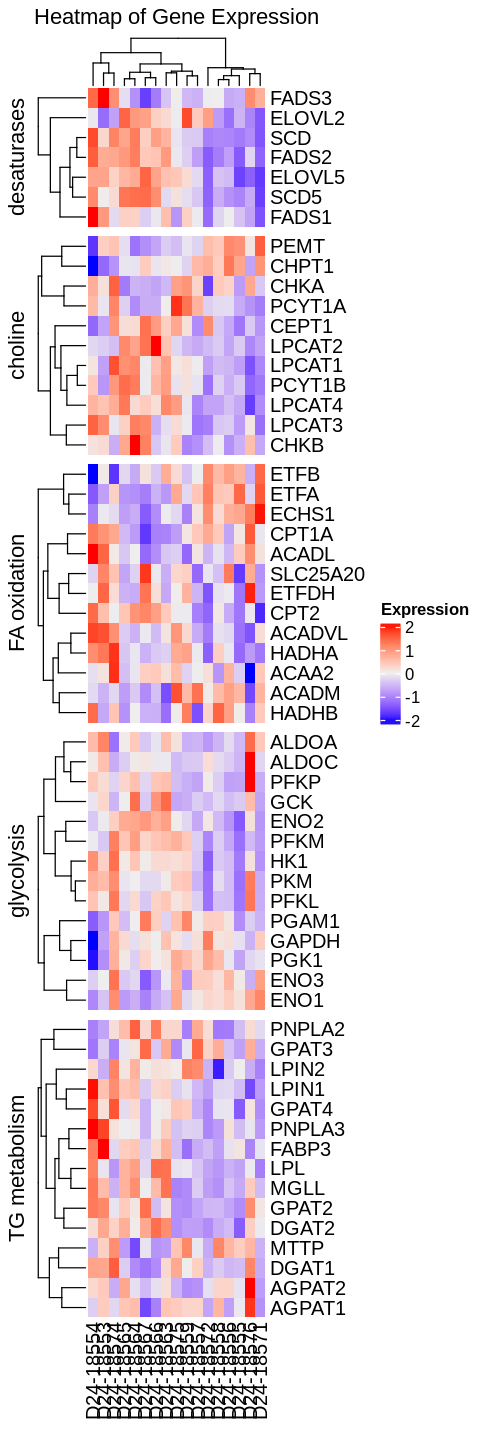

In [55]:
# Change figure size
options(repr.plot.width=5, repr.plot.height=4)

genes = list(c('SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 'ELOVL2', 'ELOVL5', 'ACSL'),
             c('CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4'),
             c('ACADM', 'ACADVL', 'ACADL', 'CPT1A', 'CPT1B', 'CPT2', 'SLC25A20', 'HADHA', 'HADHB', 'ACAA2', 'ECHS1', 'ETFA', 'ETFB', 'ETFDH'),
             c('HK1', 'HK2', 'HK3', 'GCK', 'PGI', 'PFKL', 'PFKM', 'PFKP', 'ALDOA', 'ALDOB', 'ALDOC', 'GAPDH', 'PGK1', 'PGAM1', 'PGAM2', 'ENO1', 'ENO2', 'ENO3', 'PKM', 'PKLR'),
             c('DGAT1', 'DGAT2', 'GPAT1', 'GPAT2', 'GPAT3', 'GPAT4', 'AGPAT1', 'AGPAT2', 'LPIN1', 'LPIN2', 'LPIN3', 'MGLL', 'PNPLA2', 'PNPLA3', 'LPL', 'APOB', 'MTTP', 'ANGPTL3', 'ANGPTL4', 'ANGPTL8', 'CETP', 'FABP1', 'FABP2', 'FABP3'))
library(ComplexHeatmap)
titles = c('desaturases', 'choline', 'FA oxidation', 'glycolysis', 'TG metabolism')
out = list()
for(i in 1:length(genes)){
    x = as.data.frame(cpm(subset_x$counts)[subset_x$genes$genes%in%genes[[i]],])
    row.names(x) = subset_x$genes$genes[subset_x$genes$genes%in%genes[[i]]]

    # Prepare the data for the heatmap
    heatmap_data <- as.matrix(x)  # Exclude the 'genes' column

    # Plot the heatmap using ComplexHeatmap
    f = Heatmap(t(scale(t(heatmap_data))), 
            name = "Expression", 
            cluster_rows = TRUE, 
            cluster_columns = TRUE, 
            show_row_names = TRUE, 
            show_column_names = TRUE, 
            column_title = "Heatmap of Gene Expression",
            row_title = titles[i])
    out[[i]] = f
}

options(repr.plot.width=4, repr.plot.height=12)

out[[1]] %v% out[[2]] %v% out[[3]] %v% out[[4]] %v% out[[5]]



In [54]:
heatmap_data

D24-18553,D24-18554,D24-18555,D24-18556,D24-18557,D24-18558,D24-18559,D24-18563,D24-18564,D24-18565,D24-18566,D24-18567,D24-18571,D24-18572,D24-18574,D24-18575,D24-18576


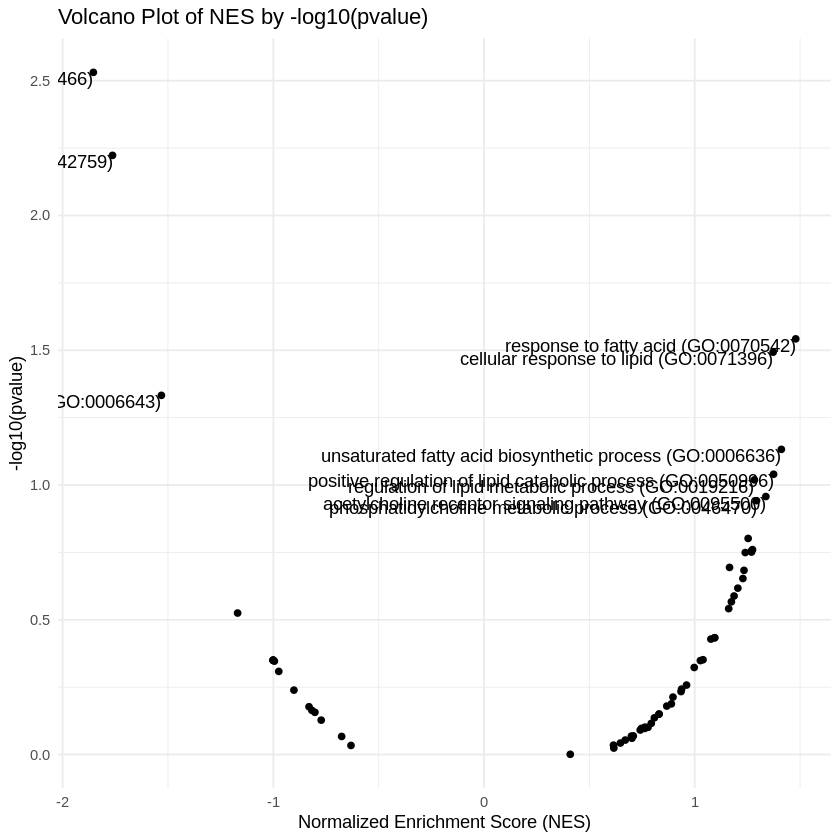

In [45]:
library(ggplot2)

# Extract the first output
output1 <- outputs[[3]]

# Calculate -log10(pval) for plotting
output1$logpvalue <- -log10(output1$pval)

# Select top pathways for labeling
top_pathways <- head(output1[order(output1$pval), ], 10)

# Create the volcano plot
ggplot(output1, aes(x = NES, y = logpvalue)) +
  geom_point() +
  geom_text(data = top_pathways, aes(label = pathway), vjust = 1, hjust = 1) +
  labs(title = "Volcano Plot of NES by -log10(pvalue)",
       x = "Normalized Enrichment Score (NES)",
       y = "-log10(pvalue)") +
  theme_minimal()

In [25]:
library(fgsea)
res_g2$scores = sign(res_g2$logFC)*-log10(res_g2$P.Value)
scores = res_g2$scores
names(scores) = res_g2$genes
pathways = readRDS('/home/gridsan/djuna/homer/github/archived_repos/APOE_myelin_2022/re-submission_code_31012022/data/pathways.rds')
related_pathways = pathways$pathways$all_bp[grep("choline", names(pathways$pathways$all_bp), value = TRUE)]
out = fgsea(pathways = related_pathways, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
out[order(out$pval),]

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
phosphatidylcholine acyl-chain remodeling (GO:0036151),0.02121945,0.1144337,0.11404767,-0.6511847,-1.5455698,14,"PLA2G3 , PLA2G4C, MBOAT2 , LPCAT3 , PLB1"
phosphatidylcholine metabolic process (GO:0046470),0.03814457,0.1144337,0.07890358,-0.4863553,-1.4336262,43,"PLA2G3 , PLA2G4C, MBOAT2 , ABHD3 , LPCAT3 , ABHD4 , GPLD1 , LPIN1 , PLB1 , SLC44A3, SLC27A1, SLC44A1, SLC44A2"
acetylcholine receptor signaling pathway (GO:0095500),0.14073392,0.2115680,0.04168918,-0.5329071,-1.3032781,16,"LYNX1 , CHRNA7, CHRM3 , GRK2"
"synaptic transmission, cholinergic (GO:0007271)",0.14104535,0.2115680,0.04102642,-0.5085506,-1.3023574,20,"SLC5A7 , CHRNA7 , CHRFAM7A, APOE , CHRM3"
phosphatidylcholine biosynthetic process (GO:0006656),0.72331967,0.8379623,0.01222313,-0.3052051,-0.8256149,26,"ABHD3 , LPIN1 , SLC44A3, SLC27A1, SLC44A1, SLC44A2"
G-protein coupled acetylcholine receptor signaling pathway (GO:0007213),0.83796234,0.8379623,0.01133223,-0.3104460,-0.7229107,13,"CHRM3 , GRK2 , DHX8 , CDK5R1, GNA11 , GNAQ , GNB1"


In [9]:
#out[order(out$pval),]


In [50]:
res_y622[grep("^ELOV", res_y622$genes),]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1795,ELOVL1,-0.52108762,3.3632481,-3.38060918,0.005193092,0.04418239,-2.983186
26475,ELOVL5,-0.40616356,7.4962482,-3.00866976,0.010483023,0.06562573,-4.119909
19043,ELOVL6,-0.38342374,6.0986869,-1.83538353,0.090398547,0.23844981,-6.075056
26822,ELOVL4,-0.16193859,8.4109113,-1.82045734,0.092758005,0.24213215,-6.260289
21717,ELOVL7,-0.62526655,-0.3760178,-1.60498491,0.133507200,0.30327505,-5.209747
24779,ELOVL2,0.11575433,3.8344541,0.70887456,0.491441261,0.66605481,-7.112727
41615,ELOVL3,0.03534156,-0.2821708,0.09060167,0.929248008,0.96049826,-6.395355


In [11]:
res[grep("ELOV", res$genes),]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,scores
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19043,ELOVL6,-0.8086902,5.5813370,-10.1131807,8.188210e-09,5.376517e-07,9.892082,-8.0868110
26475,ELOVL5,0.4015220,7.5819974,4.5119157,2.753120e-04,2.026530e-03,-1.045491,3.5601749
41615,ELOVL3,-0.8813558,-0.7308035,-2.6296601,1.708787e-02,4.620480e-02,-3.518073,-1.7673122
26822,ELOVL4,0.1191023,8.4249588,2.1052684,4.970600e-02,1.045950e-01,-6.187534,1.3035912
21717,ELOVL7,0.5223074,-0.2780270,1.8886867,7.530185e-02,1.441346e-01,-4.950939,1.1231944
24779,ELOVL2,0.1918618,3.9603880,1.8742043,7.737296e-02,1.470788e-01,-6.059413,1.1114108
1795,ELOVL1,-0.1015841,3.1624805,-0.7527976,4.613894e-01,5.760493e-01,-7.286783,-0.3359324


Using genes as id variables



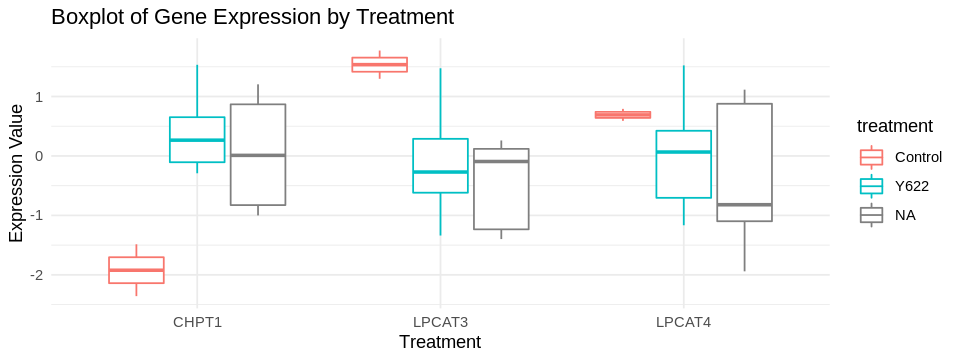

In [56]:
options(repr.plot.width=8, repr.plot.height=3)

genes = c('SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 'ELOVL2', 'ELOVL5', 'ACSL')
genes = c('CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4')
filtered_res <- res_y622[res_y622$genes %in% genes & res_y622$P.Value < 0.05, ]

x = as.data.frame(cpm(subset_x$counts)[subset_x$genes$genes%in%filtered_res$genes,])
x = as.data.frame(t(scale(t(x))))
x$genes = subset_x$genes$genes[subset_x$genes$genes%in%filtered_res$genes]

library(reshape2)
df = melt(x)
df$treatment = subset_x$samples[as.character(df$variable), 'Line']
df$treatment = factor(df$treatment, levels = c('Control', 'Y622'))
library(ggplot2)
ggplot(df, aes(x = genes, y = value, color = treatment)) +
  geom_boxplot()+# + scale_color_manual(values = c('H20' = 'blue', 'Choline2Weeks' = 'red')) +
  #geom_jitter(position = position_jitter(0.2), alpha = 0.5) +
  labs(title = "Boxplot of Gene Expression by Treatment", x = "Treatment", y = "Expression Value") +
  theme_minimal()

Warning message:
"Heatmap/annotation names are duplicated: Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression,
Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression,
Expression, Expression"


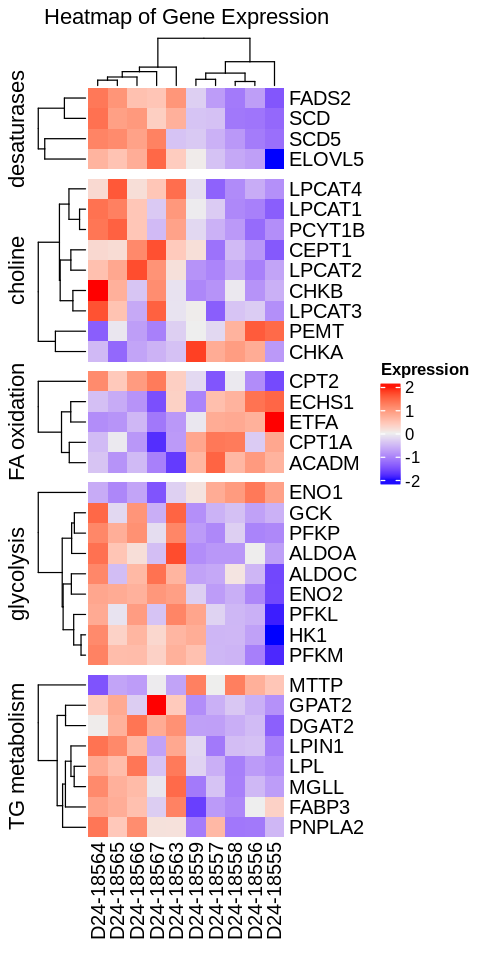

In [108]:
# Change figure size
options(repr.plot.width=5, repr.plot.height=4)
# create DGEList
x = DGEList(counts=counts_pc,genes=names, samples=metadata)
# compute DEGs
isexpr = rowSums(cpm(x) >= 1) >= 1
x = x[isexpr,]

subset_x = x[,grepl("batch 1", x$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Line=='Y622']

genes = list(c('SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 'ELOVL2', 'ELOVL5', 'ACSL'),
             c('CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4'),
             c('ACADM', 'ACADVL', 'ACADL', 'CPT1A', 'CPT1B', 'CPT2', 'SLC25A20', 'HADHA', 'HADHB', 'ACAA2', 'ECHS1', 'ETFA', 'ETFB', 'ETFDH'),
             c('HK1', 'HK2', 'HK3', 'GCK', 'PGI', 'PFKL', 'PFKM', 'PFKP', 'ALDOA', 'ALDOB', 'ALDOC', 'GAPDH', 'PGK1', 'PGAM1', 'PGAM2', 'ENO1', 'ENO2', 'ENO3', 'PKM', 'PKLR'),
             c('DGAT1', 'DGAT2', 'GPAT1', 'GPAT2', 'GPAT3', 'GPAT4', 'AGPAT1', 'AGPAT2', 'LPIN1', 'LPIN2', 'LPIN3', 'MGLL', 'PNPLA2', 'PNPLA3', 'LPL', 'APOB', 'MTTP', 'ANGPTL3', 'ANGPTL4', 'ANGPTL8', 'CETP', 'FABP1', 'FABP2', 'FABP3'))
library(ComplexHeatmap)
titles = c('desaturases', 'choline', 'FA oxidation', 'glycolysis', 'TG metabolism')
out = list()
for(i in 1:length(genes)){
    filtered_res <- res_choline[res_choline$genes %in% genes[[i]] & res_choline$P.Value < 0.05, ]
    x = as.data.frame(cpm(subset_x$counts)[subset_x$genes$genes%in%filtered_res$genes,])
    row.names(x) = subset_x$genes$genes[subset_x$genes$genes%in%filtered_res$genes]

    # Prepare the data for the heatmap
    heatmap_data <- as.matrix(x)  # Exclude the 'genes' column

    # Plot the heatmap using ComplexHeatmap
    f = Heatmap(t(scale(t(heatmap_data))), 
            name = "Expression", 
            cluster_rows = TRUE, 
            cluster_columns = TRUE, 
            show_row_names = TRUE, 
            show_column_names = TRUE, 
            column_title = "Heatmap of Gene Expression",
            row_title = titles[i])
    out[[i]] = f
}

options(repr.plot.width=4, repr.plot.height=8)

out[[1]] %v% out[[2]] %v% out[[3]] %v% out[[4]] %v% out[[5]]



In [110]:
# Change figure size
options(repr.plot.width=5, repr.plot.height=4)
# create DGEList
x = DGEList(counts=counts_pc,genes=names, samples=metadata)
# compute DEGs
isexpr = rowSums(cpm(x) >= 1) >= 1
x = x[isexpr,]

subset_x = x[,grepl("batch 2", x$samples$Notes)]
subset_x = subset_x[,subset_x$samples$Line=='Y622']

genes = list(c('SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 'ELOVL2', 'ELOVL5', 'ACSL'),
             c('CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4'),
             c('ACADM', 'ACADVL', 'ACADL', 'CPT1A', 'CPT1B', 'CPT2', 'SLC25A20', 'HADHA', 'HADHB', 'ACAA2', 'ECHS1', 'ETFA', 'ETFB', 'ETFDH'),
             c('HK1', 'HK2', 'HK3', 'GCK', 'PGI', 'PFKL', 'PFKM', 'PFKP', 'ALDOA', 'ALDOB', 'ALDOC', 'GAPDH', 'PGK1', 'PGAM1', 'PGAM2', 'ENO1', 'ENO2', 'ENO3', 'PKM', 'PKLR'),
             c('DGAT1', 'DGAT2', 'GPAT1', 'GPAT2', 'GPAT3', 'GPAT4', 'AGPAT1', 'AGPAT2', 'LPIN1', 'LPIN2', 'LPIN3', 'MGLL', 'PNPLA2', 'PNPLA3', 'LPL', 'APOB', 'MTTP', 'ANGPTL3', 'ANGPTL4', 'ANGPTL8', 'CETP', 'FABP1', 'FABP2', 'FABP3'))
library(ComplexHeatmap)
titles = c('desaturases', 'choline', 'FA oxidation', 'glycolysis', 'TG metabolism')
out = list()
for(i in 1:length(genes)){
    filtered_res <- res_choline_batch2[res_choline_batch2$genes %in% genes[[i]] & res_choline_batch2$P.Value < 0.05, ]
    x = as.data.frame(cpm(subset_x$counts)[subset_x$genes$genes%in%filtered_res$genes,])
    row.names(x) = subset_x$genes$genes[subset_x$genes$genes%in%filtered_res$genes]

    # Prepare the data for the heatmap
    heatmap_data <- as.matrix(x)  # Exclude the 'genes' column

    # Plot the heatmap using ComplexHeatmap
    f = Heatmap(t(scale(t(heatmap_data))), 
            name = "Expression", 
            cluster_rows = TRUE, 
            cluster_columns = TRUE, 
            show_row_names = TRUE, 
            show_column_names = TRUE, 
            column_title = "Heatmap of Gene Expression",
            row_title = titles[i])
    out[[i]] = f
}

options(repr.plot.width=4, repr.plot.height=8)

out[[1]] %v% out[[2]] %v% out[[3]] %v% out[[4]] %v% out[[5]]



ERROR: Error in `.rowNamesDF<-`(x, value = value): invalid 'row.names' length


In [102]:
# Change figure size
options(repr.plot.width=5, repr.plot.height=4)

genes = list(c('SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 'ELOVL2', 'ELOVL5', 'ACSL'),
             c('CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4'),
             c('ACADM', 'ACADVL', 'ACADL', 'CPT1A', 'CPT1B', 'CPT2', 'SLC25A20', 'HADHA', 'HADHB', 'ACAA2', 'ECHS1', 'ETFA', 'ETFB', 'ETFDH'),
             c('HK1', 'HK2', 'HK3', 'GCK', 'PGI', 'PFKL', 'PFKM', 'PFKP', 'ALDOA', 'ALDOB', 'ALDOC', 'GAPDH', 'PGK1', 'PGAM1', 'PGAM2', 'ENO1', 'ENO2', 'ENO3', 'PKM', 'PKLR'),
             c('DGAT1', 'DGAT2', 'GPAT1', 'GPAT2', 'GPAT3', 'GPAT4', 'AGPAT1', 'AGPAT2', 'LPIN1', 'LPIN2', 'LPIN3', 'MGLL', 'PNPLA2', 'PNPLA3', 'LPL', 'APOB', 'MTTP', 'ANGPTL3', 'ANGPTL4', 'ANGPTL8', 'CETP', 'FABP1', 'FABP2', 'FABP3'))
library(ComplexHeatmap)
titles = c('desaturases', 'choline', 'FA oxidation', 'glycolysis', 'TG metabolism')
out = list()
for(i in 1:length(genes)){
    filtered_res <- res_choline[res_choline$genes %in% genes[[i]] & res_choline$adj.P.Val < 0.05, ]
    x = as.data.frame(cpm(subset_x$counts)[subset_x$genes$genes%in%filtered_res$genes,])
    row.names(x) = subset_x$genes$genes[subset_x$genes$genes%in%filtered_res$genes]

    # Prepare the data for the heatmap
    heatmap_data <- as.matrix(x)  # Exclude the 'genes' column

    # Plot the heatmap using ComplexHeatmap
    f = Heatmap(t(scale(t(heatmap_data))), 
            name = "Expression", 
            cluster_rows = TRUE, 
            cluster_columns = TRUE, 
            show_row_names = TRUE, 
            show_column_names = TRUE, 
            column_title = "Heatmap of Gene Expression",
            row_title = titles[i])
    out[[i]] = f
}


Warning message:
"Heatmap/annotation names are duplicated: Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression,
Expression"
Warning message:
"Heatmap/annotation names are duplicated: Expression, Expression,
Expression, Expression"


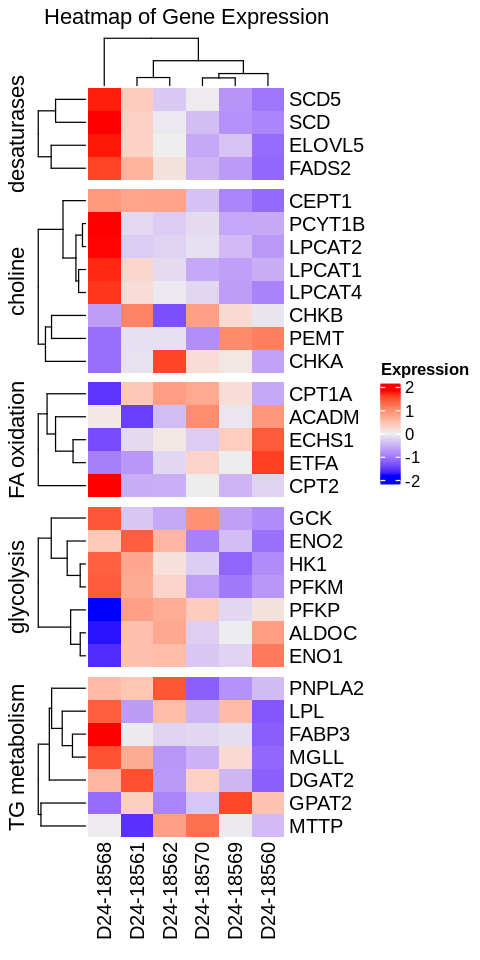

In [103]:
options(repr.plot.width=4, repr.plot.height=8)

out[[1]] %v% out[[2]] %v% out[[3]] %v% out[[4]] %v% out[[5]]


In [10]:
library(GSVA)

Using genes as id variables



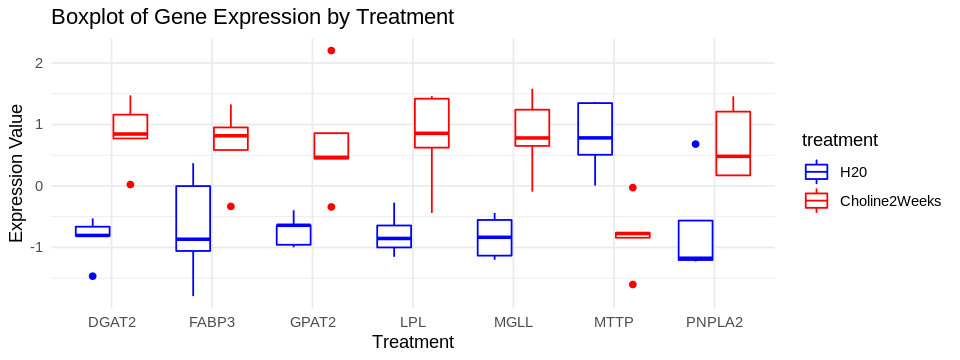

In [41]:
options(repr.plot.width=8, repr.plot.height=3)

genes = c('SCD', 'SCD5', 'FADS1', 'FADS2', 'FADS3', 'ELOVL2', 'ELOVL5', 'ACSL')
#genes <- c('CHKA', 'CHKB', 'PCYT1A', 'PCYT1B', 'CHPT1', 'CEPT1', 'PEMT', 'LPCAT1', 'LPCAT2', 'LPCAT3', 'LPCAT4')
#genes = c('ACADM', 'ACADVL', 'ACADL', 'CPT1A', 'CPT1B', 'CPT2', 'SLC25A20', 'HADHA', 'HADHB', 'ACAA2', 'ECHS1', 'ETFA', 'ETFB', 'ETFDH')
#genes = c('HK1', 'HK2', 'HK3', 'GCK', 'PGI', 'PFKL', 'PFKM', 'PFKP', 'ALDOA', 'ALDOB', 'ALDOC', 'GAPDH', 'PGK1', 'PGAM1', 'PGAM2', 'ENO1', 'ENO2', 'ENO3', 'PKM', 'PKLR')
genes = c('DGAT1', 'DGAT2', 'GPAT1', 'GPAT2', 'GPAT3', 'GPAT4', 'AGPAT1', 'AGPAT2', 'LPIN1', 'LPIN2', 'LPIN3', 'MGLL', 'PNPLA2', 'PNPLA3', 'LPL', 'APOB', 'MTTP', 'ANGPTL3', 'ANGPTL4', 'ANGPTL8', 'CETP', 'FABP1', 'FABP2', 'FABP3')

filtered_res <- res[res$genes %in% genes & res$adj.P.Val < 0.05, ]

x = as.data.frame(cpm(subset_x$counts)[subset_x$genes$genes%in%filtered_res$genes,])
x = as.data.frame(t(scale(t(x))))
x$genes = subset_x$genes$genes[subset_x$genes$genes%in%filtered_res$genes]

library(reshape2)
df = melt(x)
df$treatment = subset_x$samples[as.character(df$variable), 'Treatment']
df$treatment = factor(df$treatment, levels = c('H20', 'Choline2Weeks'))
library(ggplot2)
ggplot(df, aes(x = genes, y = value, color = treatment)) +
  geom_boxplot() + scale_color_manual(values = c('H20' = 'blue', 'Choline2Weeks' = 'red')) +
  #geom_jitter(position = position_jitter(0.2), alpha = 0.5) +
  labs(title = "Boxplot of Gene Expression by Treatment", x = "Treatment", y = "Expression Value") +
  theme_minimal()

In [24]:
# compute fgsea results rs3752246
paths = read.csv('./supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}   

In [34]:
out = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
out[order(out$pval),]


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
7,6.659237e-09,5.327389e-08,0.76146080,-0.7269863,-2.4865803,41,"COX7A2 , NDUFB8 , UQCR10 , COX6A1 , NDUFA6 , COX7A2L, NDUFS4 , NDUFA10, ATP5MG , COX5B , ATP5PB , NDUFA4 , SDHC , NDUFB9 , NDUFS3 , COX4I1 , COX7B , ATP5PO , NDUFC2 , COX5A , COX6C , NDUFB10, NDUFA5 , COX6B1 , NDUFC1 , NDUFA2 , NDUFA11"
3,2.213739e-06,8.854956e-06,0.62725674,-0.6591009,-2.2288584,39,"PSMB5 , PSMD14 , PSMC2 , PSMB3 , PSMB1 , PSMB7 , ATP5F1C, PSMA5 , PSMC1 , PSMA6 , PSMD4 , CEP162 , IFT46 , PSMD6 , PSMC3 , PSMD11 , PSMC4 , PSMB2 , PSMC5 , BBS4"
0,3.497444e-03,9.326518e-03,0.28531339,0.5886629,1.6564639,35,"NPY1R , GABRG3 , GABRA2 , GABRG2 , GABRG1 , FH , GABRA5 , SLC6A11, GABRB3 , ALDH9A1, AP2A1 , GABBR1 , ECT2"
6,2.248258e-02,4.496517e-02,0.17121432,-0.6045868,-1.6495606,16,"CASP3, HRK , BID , PTRH2, MAX"
5,9.889241e-02,1.582278e-01,0.09018882,-0.3885850,-1.2978397,36,"SMC2 , RPA2 , TFDP2 , ANAPC5, DNMT1 , ORC5 , RFC3 , ORC6 , SKP1 , MAT2B , RBX1 , SMC3 , ANAPC1, CDC27"
1,2.430939e-01,3.241252e-01,0.05633350,-0.3389484,-1.1378764,37,"ARID4B , BARD1 , RNF168 , SMARCC2, SMC1A , KMT2C , RAD50"
2,3.771954e-01,4.310804e-01,0.02343391,0.3934811,1.0689326,29,"ACSS2 , ACLY , SREBF2, FASN , NCOA1 , PPARD , SREBF1, MXD1 , ESRRA"
4,7.455587e-01,7.455587e-01,0.01385163,0.3202120,0.8052705,20,"LDLR , LTBP1 , SOS1 , CTNNB1, SOS2 , AKT3 , MSH6 , TGFB2"


In [32]:
x = res[res$genes%in%unname(unlist(P)),]
x = x[x$adj.P.Val<0.05,]
x


,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,scores
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19957,NPY1R,1.2675813,4.811121,17.597786,1.015316e-12,3.268328e-10,19.30909025,11.993399
20338,CASP3,-0.7766200,9.036957,-16.951113,1.910544e-12,5.481600e-10,18.34151653,-11.718843
26749,COX7A2,-1.2574459,9.397407,-13.578141,7.623128e-11,1.242099e-08,14.47314454,-10.117867
49799,HRK,-0.8526912,5.949852,-12.296480,3.800630e-10,4.410697e-08,13.04752361,-9.420144
41208,PTEN,-0.6793483,6.060869,-10.098164,8.376758e-09,5.473092e-07,9.81776330,-8.076924
55593,GABRG3,1.2702647,2.510771,8.705317,7.732938e-08,3.390675e-06,8.09070964,7.111655
71143,ACSS2,0.6854601,5.759868,8.516823,1.063385e-07,4.331653e-06,7.21216789,6.973309
38027,SMC2,-0.7352331,4.457591,-8.398425,1.301906e-07,5.206834e-06,7.17488355,-6.885420
73441,BID,-0.4522236,6.870449,-8.371513,1.363528e-07,5.436812e-06,6.84551493,-6.865336


In [6]:
names(pathways$pathways)

[1] "low_removed_reactome"   "low_removed_kegg"       "low_removed_humancyc"  
 [4] "low_removed_bp"         "all_reactome"           "all_kegg"              
 [7] "all_humancyc"           "all_bp"                 "all"                   
[10] "apoe_gsets_low_removed" "apoe_gsets_all"

In [10]:
# compute fgsea results rs3752246
paths = read.csv('../../../../ABCA7lof2/processed_data/genesets/all_paths.csv', check.names=FALSE)
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are duplicate gene names, fgsea may produce unexpected results."


In [1]:
paths

ERROR: Error in eval(expr, envir, enclos): object 'paths' not found


In [32]:
out[order(out$pval),]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
unsaturated fatty acid metabolic process (GO:0033559),0.0007738524,0.003869262,0.47727082,-0.6312719,-1.739733,32,"CYP1B1 , PLA2G4C, FADS2 , MGLL , SCD , CYP4A11, FADS3 , ELOVL1 , FADS1 , ELOVL5 , SCD5 , ACAA1"
unsaturated fatty acid biosynthetic process (GO:0006636),0.0950781364,0.154460518,0.05469477,-0.6511644,-1.361461,9,"SCD , FADS3, FADS1, SCD5 , DECR2, HPGD"
"fatty acid elongation, monounsaturated fatty acid (GO:0034625)",0.1544605184,0.154460518,0.04270209,-0.6542116,-1.288484,7,"ELOVL1, ELOVL5, ELOVL6, ELOVL4, ELOVL7"
"fatty acid elongation, polyunsaturated fatty acid (GO:0034626)",0.1544605184,0.154460518,0.04270209,-0.6542116,-1.288484,7,"ELOVL1, ELOVL5, ELOVL6, ELOVL4, ELOVL7"
"fatty acid elongation, unsaturated fatty acid (GO:0019368)",0.1544605184,0.154460518,0.04270209,-0.6542116,-1.288484,7,"ELOVL1, ELOVL5, ELOVL6, ELOVL4, ELOVL7"


In [93]:
f = out[order(out$pval),]
f[f$NES>0 & f$padj<0.05,]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
anterograde trans-synaptic signaling (GO:0098916),1.430938e-06,0.0002101571,0.6435518,0.5035047,1.771658,173,"PRLHR , SLC18A3 , HTR3A , NPY1R , OPRK1 , GABRE , PCDHB2 , GABRA3 , HTR3B , NPY , GABRB1 , MBP , GABRG3 , CACNA1E , UTS2 , HAP1 , NPTX2 , KCNC4 , DLG2 , CHRNA3 , GRIA1 , GPR176 , GABRA2 , AMPH , ASIC2 , GABRG2 , UNC13B , BSN , PCDHB15 , GABRG1 , SYT1 , NPY5R , GABRQ , PCDHB14 , CHRNA5 , HTR7 , DLG1 , CACNB1 , HOMER1 , KIF5A , GLRA2 , GABRA5 , DTNA , DLG3 , SLC12A7 , SLC1A1 , GPR88 , HTR2C , GAD1 , GABRB3 , DRD5 , HCRTR1 , HCRTR2 , PCDHB3 , SCN2B , HTR6 , KCNK3 , CHRNB4 , GRIK2 , KCNN1 , LRP6 , MAPK1 , AKAP5 , PAFAH1B1, CNP , SYN1"
chemical synaptic transmission (GO:0007268),3.005234e-06,0.0004012442,0.6272567,0.4817050,1.720822,208,"PRLHR , SLC5A7 , SLC18A3 , HTR3A , NPY1R , OPRK1 , GABRE , PCDHB2 , GABRA3 , HTR3B , NPY , GABRB1 , MBP , GABRG3 , CACNA1E , UTS2 , HAP1 , NPTX2 , KCNC4 , DLG2 , PDLIM4 , CHRNA3 , GRIA1 , GPR176 , GABRA2 , AMPH , ASIC2 , GABRG2 , DLGAP2 , UNC13B , BSN , PCDHB15 , GABRG1 , SYT1 , NPY5R , GABRQ , PCDHB14 , CHRNA5 , HTR7 , DLG1 , CACNB1 , HOMER1 , KIF5A , GLRA2 , GABRA5 , NAPB , DTNA , DLG3 , SLC12A7 , SLC1A1 , GPR88 , HTR2C , GAD1 , GABRB3 , DRD5 , HCRTR1 , HCRTR2 , PCDHB3 , SCN2B , DRD2 , HTR6 , KCNK3 , ADRA1D , CHRNB4 , GRIK2 , KCNN1 , LRP6 , MAPK1 , AKAP5 , PAFAH1B1, CNP , SYN1"
negative regulation of MAP kinase activity (GO:0043407),3.517295e-06,0.0004558001,0.6272567,0.6637485,1.980848,47,"DUSP6 , RGS4 , RGS3 , RGS2 , IRAK3 , SPRED1, SPRY4 , DUSP3 , DUSP22, PRKCD , NF1 , DUSP10, PAQR3 , SPRED2, DUSP8"
cellular response to organonitrogen compound (GO:0071417),3.413366e-05,0.0034180209,0.5573322,0.5816908,1.861449,73,"RRAGB , SFRP1 , GABRB1 , SH3BP4 , CPEB1 , GABRG2 , SESN1 , IMPACT , SESN3 , LARP1 , HSP90B1, GLRA2 , SLIT2 , HCN4 , ACTB , RAPGEF2, P2RX4 , PDE2A , MTOR , RRAGD , GABRB3 , CTNNB1 , DMTN , DHX8 , CAPN2 , CPEB4 , RAP1A , CPEB3 , RAPGEF1, IPO5 , IGFBP5 , SESN2 , SSH1 , GABRB2 , AKAP6 , MAPK13"
calcium ion transport (GO:0006816),4.133880e-05,0.0040475274,0.5573322,0.5551794,1.800445,81,"NPY , TRPC7 , RAMP1 , CACNA1E, SLC24A3, CACNG2 , ATP2B4 , ITGAV , CACNG3 , CACNA1I, ATP2A2 , NALCN , ANO6 , TRPC1 , ORAI2 , CACNG4 , P2RX4 , ANK2 , TRPV2 , ATP2C1 , ATP2B2 , TRPM3 , CACNA1H, SLC24A2, CACNA1A, TRPC4 , TRPC4AP, SLC8A3 , CACNA1G, ORAI3 , CACNB2 , GAS6 , CCL3"
fatty-acyl-CoA metabolic process (GO:0035337),4.578673e-05,0.0043855724,0.5573322,0.7903791,1.897739,16,"FAR2 , SCD , HSD17B4, DGAT2 , ACLY , FAR1 , SCD5 , FASN , SLC25A1"
chloride transmembrane transport (GO:1902476),6.032036e-05,0.0056547132,0.5573322,0.6584111,1.889936,38,"GABRE , GABRA3 , CLCN4 , GABRB1 , GABRG3 , SLC26A11, GABRA2 , GABRG2 , GABRG1 , CLCN6 , CLCN3 , SLC12A1 , GLRA2 , GABRA5 , ANO6 , SLC12A7 , SLC1A1 , CLIC5 , GABRB3"
inorganic anion transmembrane transport (GO:0098661),7.088059e-05,0.0063734665,0.5384341,0.6469275,1.908145,44,"GABRE , GABRA3 , CLCN4 , GABRB1 , GABRG3 , SLC26A11, GABRA2 , GABRG2 , GABRG1 , XPR1 , CLCN6 , CLCN3 , SLC12A1 , GLRA2 , GABRA5 , ANO6 , SLC12A7 , SLC1A1 , CLIC5 , SLC37A4 , GABRB3"
receptor localization to synapse (GO:0097120),1.169394e-04,0.0097214134,0.5384341,0.7687112,1.891483,18,"DLG2 , CACNG2, NLGN1 , CACNG3, DLG1 , KIF5A , CACNG4, DLG3 , GPHN , KIF17"


In [50]:
library(fgsea)

In [ ]:


index = x$samples$ID%in%c('A', 'B', 'C', 'D', 'E', 'F')
experiment1 = x[,index]
experiment2 = x[,!index]

exp1_out = list()
grps = list(c('DMSO', 'p53ac_10'), c('DMSO', 'p53ac_100'))
for(x in grps){
    subset = experiment1[,experiment1$samples$group3%in%x]
    subset$samples$group3 = factor(subset$samples$group3, levels = x)
    mod1 = model.matrix(~subset$samples$group3)
    colnames(mod1) = c('intercept', 'condition')
    v = voom(subset, design=mod1, plot = TRUE)
    fit = lmFit(v, design=mod1)
    fit = eBayes(fit)
    res = topTable(fit, coef='condition', n=Inf, sort.by="P")
    name = paste0(x, collapse = '_')
    res$grp = name
    exp1_out[[name]] = res
}
